In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import torchvision
from torchvision import datasets
from torchvision import transforms


import PIL
from PIL import Image

In [68]:
class SiameseNetworkDataset(data.Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            img1_tuple = random.choice(self.imageFolderDataset.imgs)

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [238]:
BATCH_SIZE = 32
NUM_EPOCH = 10
LRATE = 0.001

In [220]:
train_path  = 'dataset/train'
valid_path  = 'dataset/valid'


tmft_train = transforms.Compose([
    transforms.Resize((112,112)),
#     transforms.RandomRotation(30),
    transforms.CenterCrop((112)),
    transforms.Grayscale(),
    transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

tmft_valid = transforms.Compose([
    transforms.Resize((112,112)),
    transforms.CenterCrop((112)),
    transforms.Grayscale(),
    transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

trainset_imagefolder = datasets.ImageFolder(train_path)
trainset = SiameseNetworkDataset(trainset_imagefolder, transform=tmft_train)
trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

valid_imagefolder = datasets.ImageFolder(valid_path)
validset = SiameseNetworkDataset(valid_imagefolder, transform=tmft_valid)
validloader = data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=True)

In [221]:
im1, im2, sim = next(iter(trainloader))

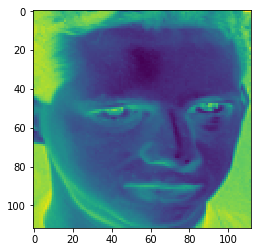

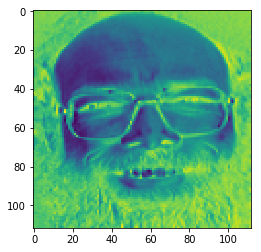

tensor([1.])


In [222]:
# plt.imshow(im1[0].permute(1,2,0));plt.show()
# plt.imshow(im2[0].permute(1,2,0));plt.show()
# print(sim[0])

plt.imshow(im1[0].squeeze());plt.show()
plt.imshow(im2[0].squeeze());plt.show()
print(sim[0])

# im1.squeeze()

In [223]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*112*112, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 32)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
    
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        if torch.cuda.is_available():
            euclidean_distance = euclidean_distance.cpu()
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [239]:
model = SiameseNetwork()
if torch.cuda.is_available():
    model = model.cuda()

criterion = ContrastiveLoss()
optimizer = optim.SGD(model.parameters(), lr=LRATE)

In [240]:
# img1, img2, label = next(iter(trainloader))

# if torch.cuda.is_available():
#     img1 = img1.cuda()
#     img2 = img2.cuda()

# optimizer.zero_grad()
# output1, output2 = model.forward(img1, img2) #forward prop
# loss = criterion(output1, output2, label)
# loss.backward()
# optimizer.step()
# print(loss)

In [241]:

for epoch in range(NUM_EPOCH):
    
    model.train()
    for idx, (img1,img2,label) in enumerate(trainloader):
        if torch.cuda.is_available():
            img1 = img1.cuda()
            img2 = img2.cuda()
            
        optimizer.zero_grad()
        output1, output2 = model.forward(img1, img2) #forward prop
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch} \tTrain Loss: {loss}')
        
    model.eval()
    with torch.no_grad():
        for idx, (img1,img2,label) in enumerate(trainloader):
            if torch.cuda.is_available():
                img1 = img1.cuda()
                img2 = img2.cuda()

            output1, output2 = model.forward(img1, img2) #forward prop
            loss = criterion(output1, output2, label)
            print(f'Epoch {epoch} \tValid Loss: {loss}')
        
    

RuntimeError: CUDA out of memory. Tried to allocate 191.50 MiB (GPU 0; 3.95 GiB total capacity; 2.44 GiB already allocated; 201.56 MiB free; 159.09 MiB cached)